In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
combined_df = pd.read_csv('C:/Users/DELL G7/Pictures/Camera Roll/projects/newdepression/combined_data.csv')

In [4]:
combined_df.tail()

,timestamp,activity,status,person
1571701,2002-06-28 09:40:00,0,depressed,condition_23
1571702,2002-06-28 09:41:00,0,depressed,condition_23
1571703,2002-06-28 09:42:00,48,depressed,condition_23
1571704,2002-06-28 09:43:00,0,depressed,condition_23
1571705,2002-06-28 09:44:00,0,depressed,condition_23


In [5]:
# Preprocessing: converting categorical labels to integer values
mapping = {'depressed': 1, 'nondepressed': 0}
combined_df['status'] = combined_df['status'].map(mapping)

In [6]:
combined_df.head()

,timestamp,activity,status,person
0,2003-03-18 15:00:00,60,0,control_1
1,2003-03-18 15:01:00,0,0,control_1
2,2003-03-18 15:02:00,264,0,control_1
3,2003-03-18 15:03:00,662,0,control_1
4,2003-03-18 15:04:00,293,0,control_1


In [7]:

# Create sequences

sequence_length = 24
sequences = []
labels = []
for person, group in combined_df.groupby('person'):
    for i in range(0, len(group) - sequence_length):
        sequences.append(group['activity'].iloc[i:i+sequence_length].values)
        labels.append(group['status'].iloc[i])

X = np.array(sequences)
y = np.array(labels)



In [8]:
nan_values_in_X = np.isnan(X)
print(f"Number of NaN values in X: {np.sum(nan_values_in_X)}")


Number of NaN values in X: 0


In [9]:
nan_values_in_y = np.isnan(y)
print(f"Number of NaN values in y: {np.sum(nan_values_in_y)}")


Number of NaN values in y: 0


In [10]:
# Convert data to PyTorch tensors


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


In [11]:
# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [12]:
# Hyperparameters
input_dim = 1
hidden_dim = 100
layer_dim = 3
output_dim = 2
learning_rate = 0.001
num_epochs = 70
batch_size = 32  # Reduced batch size


In [13]:

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
torch.cuda.empty_cache()

In [15]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_corrects = 0
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train_tensor[i:i+batch_size].view(-1, sequence_length, 1).cuda()
        batch_y = y_train_tensor[i:i+batch_size].cuda()

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == batch_y.data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_X.size(0)

    average_train_loss = train_loss / len(X_train)
    train_losses.append(average_train_loss)

    train_accuracy = train_corrects.double() / len(X_train)
    train_accuracies.append(train_accuracy.cpu().numpy())

    model.eval()
    test_loss = 0.0
    test_corrects = 0
    all_predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test_tensor[i:i+batch_size].view(-1, sequence_length, 1).cuda()
            batch_y = y_test_tensor[i:i+batch_size].cuda()

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            _, preds = torch.max(outputs, 1)
            all_predictions.extend(preds.cpu().numpy())
            test_corrects += torch.sum(preds == batch_y.data)

            test_loss += loss.item() * batch_X.size(0)

    average_test_loss = test_loss / len(X_test)
    test_losses.append(average_test_loss)

    test_accuracy = test_corrects.double() / len(X_test)
    test_accuracies.append(test_accuracy.cpu().numpy())
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    print(f'Train Loss: {average_train_loss:.4f} Train Acc: {train_accuracy:.4f}')
    print(f'Test Loss: {average_test_loss:.4f} Test Acc: {test_accuracy:.4f}')
    print()


Epoch 1/70
----------
Train Loss: 0.5930 Train Acc: 0.6807
Test Loss: 0.5846 Test Acc: 0.6873

Epoch 2/70
----------
Train Loss: 0.5808 Train Acc: 0.6919
Test Loss: 0.5828 Test Acc: 0.6899

Epoch 3/70
----------
Train Loss: 0.5758 Train Acc: 0.6963
Test Loss: 0.5763 Test Acc: 0.6946

Epoch 4/70
----------
Train Loss: 0.5712 Train Acc: 0.7008
Test Loss: 0.5706 Test Acc: 0.7006

Epoch 5/70
----------
Train Loss: 0.5646 Train Acc: 0.7066
Test Loss: 0.5663 Test Acc: 0.7089

Epoch 6/70
----------
Train Loss: 0.5556 Train Acc: 0.7146
Test Loss: 0.5527 Test Acc: 0.7154

Epoch 7/70
----------
Train Loss: 0.5436 Train Acc: 0.7237
Test Loss: 0.5412 Test Acc: 0.7258

Epoch 8/70
----------
Train Loss: 0.5295 Train Acc: 0.7341
Test Loss: 0.5283 Test Acc: 0.7352

Epoch 9/70
----------
Train Loss: 0.5157 Train Acc: 0.7430
Test Loss: 0.5153 Test Acc: 0.7439

Epoch 10/70
----------
Train Loss: 0.5023 Train Acc: 0.7518
Test Loss: 0.5066 Test Acc: 0.7499

Epoch 11/70
----------
Train Loss: 0.4904 Train A

In [16]:
# Save the model's state_dict
torch.save(model.state_dict(), 'C:/Users/DELL G7/Pictures/Camera Roll/projects/newdepression/lstm_70.pth')


In [ ]:
# # Assuming the model class is named LSTMClassifier and is defined

# # Create a model object
# loaded_model = LSTMClassifier(input_dim=1, hidden_dim=100, output_dim=2, layer_dim=3)

# # Load the model's parameters from file
# loaded_model.load_state_dict(torch.load('C:/Users/DELL G7/Pictures/Camera Roll/projects/newdepression/lstm.pth'))

# # Set the model to evaluation mode (important for models with dropout layers, batch normalization, etc.)
# loaded_model.eval()


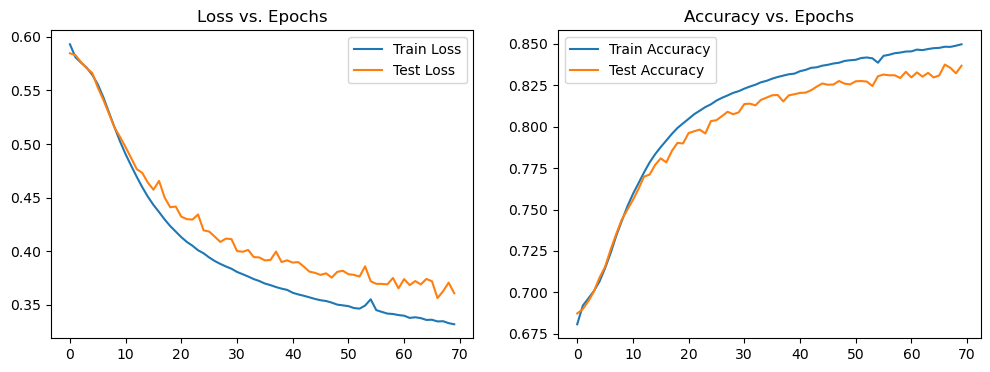

In [17]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.show()


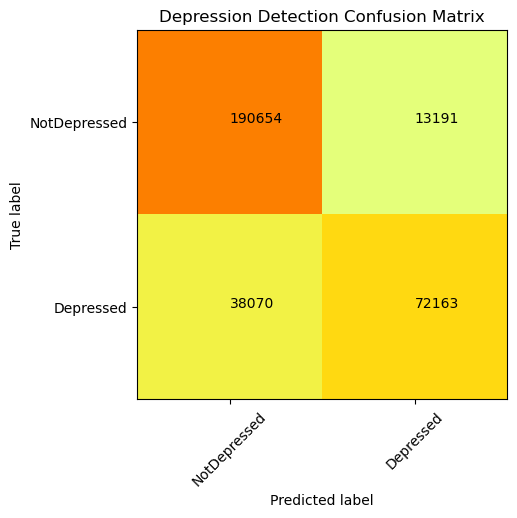

In [22]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, all_predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['NotDepressed', 'Depressed']
plt.title('Depression Detection Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i][j]))
plt.show()

In [23]:
from sklearn.metrics import classification_report

report = classification_report(y_test, all_predictions, target_names=classNames)
print(report)


              precision    recall  f1-score   support

NotDepressed       0.83      0.94      0.88    203845
   Depressed       0.85      0.65      0.74    110233

    accuracy                           0.84    314078
   macro avg       0.84      0.79      0.81    314078
weighted avg       0.84      0.84      0.83    314078



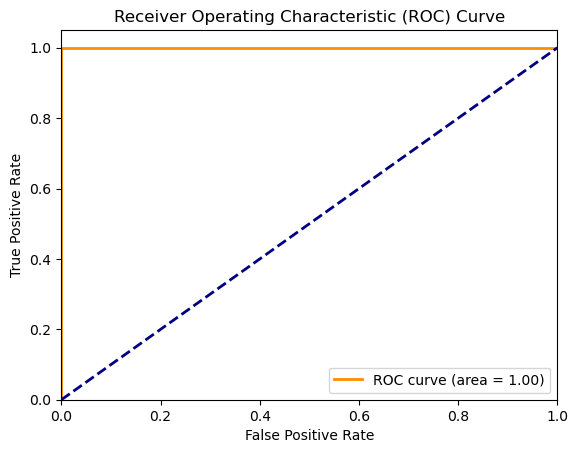

In [24]:
# ROC Curve
# ROC Curve
y_prob = nn.Softmax(dim=1)(outputs)

fpr, tpr, thresholds = roc_curve(y_test[-len(y_prob):], y_prob.cpu().detach().numpy()[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
# MCC and Cohen's Kappa
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, all_predictions))
print("Cohen's Kappa:", cohen_kappa_score(y_test, all_predictions))

Matthews Correlation Coefficient: 0.6329046593338115
Cohen's Kappa: 0.622172556339148
